In [1]:
# %pip install --quiet --upgrade pip 
# %pip install numpy --quiet
# %pip install Pandas --quiet
# %pip install sklearn --quiet
# %pip install ipywidgets --quiet

# Horse Racing Results Predictor using Linear regression #

Predict `TodaysRaceCard.csv` using simple linear regression techniques by determining predicted **speed** of a horse in a given race based on its previous performance. 

Data used here is derived from the features extracted by the [Feature Analysis](https://github.com/LeeSanderson/RacingData/blob/main/Data/FeatureAnalysis.ipynb) notebook.

## Build the model ##

In [2]:
import numpy as np
import pandas as pd
import math
from abc import ABC, abstractmethod
from datetime import datetime, date

C:\Users\leeco\AppData\Local\Temp\ipykernel_37300\3448839828.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
races = pd.read_csv("Race_Features.csv")
races['Off'] =  pd.to_datetime(races['Off'], format='%Y-%m-%d %H:%M:%S')
races.columns

Index(['RaceId', 'CourseId', 'RaceType', 'Off', 'DecimalOdds',
       'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'DistanceInMeters', 'Going', 'Surface', 'HorseId', 'HorseName',
       'JockeyId', 'JockeyName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'WeightInPounds', 'FinishingPosition',
       'OverallBeatenDistance', 'RaceTimeInSeconds', 'Wins',
       'Surface_AllWeather', 'Surface_Dirt', 'Surface_Turf', 'Going_Firm',
       'Going_Good', 'Going_Good_To_Firm', 'Going_Good_To_Soft', 'Going_Heavy',
       'Going_Soft', 'RaceType_Flat', 'RaceType_Hurdle', 'RaceType_Other',
       'RaceType_SteepleChase', 'Speed', 'HorseCount', 'KnownHorseAndJockey',
       'NumberOfPriorRaces', 'LastRaceGoing', 'LastRaceSurface',
       'LastRaceDistanceInMeters', 'LastRaceWeightInPounds', 'LastRaceSpeed',
       'DaysRested', 'LastRaceDecimalOdds', 'LastRaceOfficialRating',
       'LastRaceRacingPostRating', 'LastRaceTopSpeedRating',
       'LastRaceAvgRelFinishi

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

race_info = ['RaceId', 'CourseId', 'Off', 'HorseId', 'HorseName', 'HorseCount', 'JockeyId', 'JockeyName', 'DecimalOdds', 'Wins', 'FinishingPosition']
predictors = ([
    'DistanceInMeters', 
    'WeightInPounds', 
    'Surface_AllWeather', 'Surface_Dirt', 'Surface_Turf', 
    'Going_Firm', 'Going_Good', 'Going_Good_To_Firm', 'Going_Good_To_Soft', 'Going_Heavy', 'Going_Soft', 
    'RaceType_Flat', 'RaceType_Hurdle', 'RaceType_Other', 'RaceType_SteepleChase', 

    'LastRaceDistanceInMeters', 
    'LastRaceWeightInPounds', 
    'LastRaceSpeed',
    'DaysRested',
    'LastRaceAvgRelFinishingPosition', 
    'LastRaceSurface_AllWeather', 'LastRaceSurface_Dirt', 'LastRaceSurface_Turf', 
    'LastRaceGoing_Good', 'LastRaceGoing_Good_To_Soft', 'LastRaceGoing_Soft', 'LastRaceGoing_Good_To_Firm', 'LastRaceGoing_Firm', 'LastRaceGoing_Heavy', 
    'LastRaceRaceType_Other', 'LastRaceRaceType_Hurdle', 'LastRaceRaceType_SteepleChase', 'LastRaceRaceType_Flat', 
    
    'JockeyNumberOfPriorRaces',
    'DaysSinceJockeyLastRaced',     
    'JockeyWinPercentage',
    'JockeyTop3Percentage',
    'JockeyAvgRelFinishingPosition'
    ])
prediction = ["Speed"]

train = races[race_info + predictors + prediction].dropna().copy()

In [5]:
# Cap rested days
train.loc[train["DaysRested"] > 10, "DaysRested"] = 10
train.loc[train["DaysSinceJockeyLastRaced"] > 10, "DaysSinceJockeyLastRaced"] = 10

# Cap prior races
# train.loc[train["JockeyNumberOfPriorRaces"] > 400] = 400 (negative effect)

In [9]:
# Now that we've dropped any rows with na values, calculate which races in which we can predict the speed for all horses.
train = train.drop("PredictableHorseCount", axis=1, errors='ignore')
groups = train.groupby(['RaceId'])['HorseId'].agg(['count']).rename(columns={'count': 'PredictableHorseCount'})
train = pd.merge(train, groups, how='left', on=['RaceId'])

# 50% of races have 11 horse, 25% have 8 or less, 14% have 6 or less, 9% have 5 or less. Fewer horses should be more predictable
all_races_count = len(races["RaceId"].unique())
all_predictable = train[(train["HorseCount"] == train["PredictableHorseCount"]) & (train["HorseCount"] <= 5)]["RaceId"].unique().tolist()
all_predictable_count = len(all_predictable)
print(f"Possible predictable races = {all_predictable_count} out of {all_races_count} ({all_predictable_count * 100 / all_races_count}%)")

Possible predictable races = 4833 out of 44561 (10.845806871479544%)


In [10]:
from sklearn.model_selection import train_test_split

_, test_race_ids = train_test_split(all_predictable, test_size=0.2, random_state = 42)

test = train[train["RaceId"].isin(test_race_ids)]
train = train[train["RaceId"].isin(test_race_ids) == False]

In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create a pipeline that includes feature scaling and linear regression
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2, interaction_only=False), Ridge())

In [12]:
inputs = train[predictors]
targets = train[prediction[0]].values

In [13]:
model.fit(inputs, targets)
test_inputs = test[predictors]
predictions = model.predict(test_inputs)

In [14]:
test_with_predictions = test.copy()
test_with_predictions["PredictedSpeed"] = predictions

In [15]:
test_with_predictions["PredictedRank"] = test_with_predictions.groupby("RaceId")["PredictedSpeed"].rank(method="dense", ascending=False)

In [16]:
correct_winners = test_with_predictions[(test_with_predictions["FinishingPosition"] == 1) & (test_with_predictions["PredictedRank"] == 1)]

correct_winners_count = len(correct_winners)
incorrect_winners_count = len(test_with_predictions[(test_with_predictions["FinishingPosition"] == 1) & (test_with_predictions["PredictedRank"] != 1)])

winnings = correct_winners["DecimalOdds"].sum()
win_percentage = 100.0 * correct_winners_count / (correct_winners_count + incorrect_winners_count)

print(f"Correct winners {correct_winners_count}, Incorrect winners {incorrect_winners_count}")
print(f"Win percentage {win_percentage}")
print(f"Winnings {winnings}, losses {incorrect_winners_count}, diff  {winnings - incorrect_winners_count}")

if win_percentage < 30:
    raise ValueError("Prediction rate too low")

Correct winners 310, Incorrect winners 658
Win percentage 32.02479338842975
Winnings 1041.588480963481, losses 658, diff  383.58848096348106


## Predictions ##

In [56]:
todays_races = pd.read_csv("TodaysRaceCards.csv")
todays_races['Off'] =  pd.to_datetime(todays_races['Off'], format='%m/%d/%Y %H:%M:%S')
todays_races.columns

Index(['RaceId', 'RaceName', 'CourseId', 'CourseName', 'Off', 'RaceType',
       'Class', 'Pattern', 'RatingBand', 'AgeBand', 'SexRestriction',
       'Distance', 'DistanceInFurlongs', 'DistanceInMeters', 'DistanceInYards',
       'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'TrainerId', 'TrainerName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'Weight', 'WeightInPounds', 'FractionalOdds',
       'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating'],
      dtype='object')

### Expand categorical variables

In [57]:
surface_categories = ["Surface_AllWeather", "Surface_Dirt", "Surface_Turf"]
todays_races = todays_races.drop(surface_categories + ["Surface_Unknown"], axis=1, errors='ignore')
todays_races["SurfaceTemp"] = todays_races["Surface"]
todays_races = pd.get_dummies(todays_races, prefix="Surface", columns=["SurfaceTemp"], dtype=float)
todays_races = todays_races.drop("Surface_Unknown", axis=1, errors='ignore') # Drop unknown surface as only small number.
for surface in surface_categories:
    todays_races[surface] = todays_races.get(surface, 0.0)
todays_races[surface_categories].value_counts()

Surface_AllWeather  Surface_Dirt  Surface_Turf
1.0                 0.0           0.0             128
0.0                 0.0           1.0              46
Name: count, dtype: int64

In [58]:
# Normalise going based on rules here: https://www.racingpost.com/guide-to-racing/what-is-the-going-ann7h6W6VB3b/
# Values should be: Firm, Good_To_Firm, Good, Good_To_Soft, Soft, Heavy
norm_map = ({
    "Good": "Good", 
    "Standard": "Good",
    "Soft": "Soft",
    "Good To Soft": "Good_To_Soft",
    "Good To Firm": "Good_To_Firm",
    "Heavy": "Heavy",
    "Good To Yielding": "Good_To_Soft",    
    "Yielding": "Good_To_Soft",
    "Standard To Slow": "Good_To_Soft",  
    "Very Soft": "Heavy",
    "Fast": "Firm",
    "Firm": "Firm",
    "Soft To Heavy": "Heavy",    
    "Yielding To Soft": "Soft",
    "Slow": "Soft",
    "Sloppy": "Heavy",
    "Muddy": "Heavy",
    "Frozen": "Heavy"
})

todays_races["NormGoing"] = todays_races["Going"].map(norm_map)

In [59]:
going_categories  = ["Going_Good", "Going_Good_To_Soft", "Going_Soft", "Going_Good_To_Firm", "Going_Firm", "Going_Heavy"]
todays_races = todays_races.drop(going_categories, axis=1, errors='ignore')
todays_races = pd.get_dummies(todays_races, prefix="Going", columns=["NormGoing"], dtype=float)
for going in going_categories:
    todays_races[going] = todays_races.get(going, 0.0)

todays_races[going_categories].value_counts()

Going_Good  Going_Good_To_Soft  Going_Soft  Going_Good_To_Firm  Going_Firm  Going_Heavy
1.0         0.0                 0.0         0.0                 0.0         0.0            128
0.0         0.0                 0.0         0.0                 0.0         1.0             46
Name: count, dtype: int64

In [60]:
race_type_categories = ["RaceType_Other", "RaceType_Hurdle", "RaceType_SteepleChase", "RaceType_Flat"]
todays_races = todays_races.drop(race_type_categories, axis=1, errors='ignore')
todays_races["RaceTypeTemp"] = todays_races["RaceType"]
todays_races = pd.get_dummies(todays_races, prefix="RaceType", columns=["RaceTypeTemp"], dtype=float)
for race_type in race_type_categories:
    todays_races[race_type] = todays_races.get(race_type, 0.0)

todays_races[race_type_categories].value_counts()

RaceType_Other  RaceType_Hurdle  RaceType_SteepleChase  RaceType_Flat
1.0             0.0              0.0                    0.0              128
0.0             1.0              0.0                    0.0               31
                0.0              1.0                    0.0               15
Name: count, dtype: int64

In [61]:
todays_races.columns

Index(['RaceId', 'RaceName', 'CourseId', 'CourseName', 'Off', 'RaceType',
       'Class', 'Pattern', 'RatingBand', 'AgeBand', 'SexRestriction',
       'Distance', 'DistanceInFurlongs', 'DistanceInMeters', 'DistanceInYards',
       'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'TrainerId', 'TrainerName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'Weight', 'WeightInPounds', 'FractionalOdds',
       'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'Surface_AllWeather', 'Surface_Turf', 'Surface_Dirt', 'Going_Good',
       'Going_Heavy', 'Going_Good_To_Soft', 'Going_Soft', 'Going_Good_To_Firm',
       'Going_Firm', 'RaceType_Hurdle', 'RaceType_Other',
       'RaceType_SteepleChase', 'RaceType_Flat'],
      dtype='object')

### Load horse stats

In [62]:
horse_stats = pd.read_csv("Horse_Stats.csv")
horse_stats['LastOff'] =  pd.to_datetime(horse_stats['LastOff'], format='%Y-%m-%d %H:%M:%S')
horse_stats.columns

Index(['HorseId', 'LastOff', 'LastRaceDistanceInMeters',
       'LastRaceWeightInPounds', 'LastRaceAvgRelFinishingPosition',
       'LastRaceSurface_AllWeather', 'LastRaceSurface_Dirt',
       'LastRaceSurface_Turf', 'LastRaceGoing_Firm', 'LastRaceGoing_Good',
       'LastRaceGoing_Good_To_Firm', 'LastRaceGoing_Good_To_Soft',
       'LastRaceGoing_Heavy', 'LastRaceGoing_Soft', 'LastRaceRaceType_Flat',
       'LastRaceRaceType_Hurdle', 'LastRaceRaceType_Other',
       'LastRaceRaceType_SteepleChase', 'LastRaceSpeed'],
      dtype='object')

In [63]:
todays_races = pd.merge(todays_races, horse_stats, how="left", on=["HorseId"])

In [64]:
today = np.datetime64(datetime.today())
one_day = np.timedelta64(1, 'D')
todays_races["DaysRested"] = np.ceil((today - todays_races["LastOff"]) / one_day)
todays_races.loc[todays_races["DaysRested"] > 10, "DaysRested"] = 10
todays_races = todays_races.drop("LastOff", axis=1, errors='ignore')

In [65]:
groups = todays_races.groupby(['RaceId'])['HorseId'].agg(['count']).rename(columns={'count': 'HorseCount'})
todays_races = pd.merge(todays_races, groups, how='left', on=['RaceId'])

### Load jockey stats

In [66]:
jockey_stats = pd.read_csv("Jockey_Stats.csv")
jockey_stats['LastOff'] =  pd.to_datetime(jockey_stats['LastOff'], format='%Y-%m-%d %H:%M:%S')
jockey_stats.columns

Index(['JockeyId', 'LastOff', 'JockeyNumberOfPriorRaces',
       'JockeyWinPercentage', 'JockeyTop3Percentage',
       'JockeyAvgRelFinishingPosition'],
      dtype='object')

In [67]:
todays_races = pd.merge(todays_races, jockey_stats, how="left", on=["JockeyId"])

In [68]:
todays_races["DaysSinceJockeyLastRaced"] = np.ceil((today - todays_races["LastOff"]) / one_day)
todays_races.loc[todays_races["DaysSinceJockeyLastRaced"] > 10, "DaysSinceJockeyLastRaced"] = 10
todays_races = todays_races.drop("LastOff", axis=1, errors='ignore')

### Eliminate races that cannot be reliably predicted

In [69]:
todays_races.columns

Index(['RaceId', 'RaceName', 'CourseId', 'CourseName', 'Off', 'RaceType',
       'Class', 'Pattern', 'RatingBand', 'AgeBand', 'SexRestriction',
       'Distance', 'DistanceInFurlongs', 'DistanceInMeters', 'DistanceInYards',
       'Going', 'Surface', 'HorseId', 'HorseName', 'JockeyId', 'JockeyName',
       'TrainerId', 'TrainerName', 'Age', 'HeadGear', 'RaceCardNumber',
       'StallNumber', 'Weight', 'WeightInPounds', 'FractionalOdds',
       'DecimalOdds', 'OfficialRating', 'RacingPostRating', 'TopSpeedRating',
       'Surface_AllWeather', 'Surface_Turf', 'Surface_Dirt', 'Going_Good',
       'Going_Heavy', 'Going_Good_To_Soft', 'Going_Soft', 'Going_Good_To_Firm',
       'Going_Firm', 'RaceType_Hurdle', 'RaceType_Other',
       'RaceType_SteepleChase', 'RaceType_Flat', 'LastRaceDistanceInMeters',
       'LastRaceWeightInPounds', 'LastRaceAvgRelFinishingPosition',
       'LastRaceSurface_AllWeather', 'LastRaceSurface_Dirt',
       'LastRaceSurface_Turf', 'LastRaceGoing_Firm', 'LastRace

<Axes: >

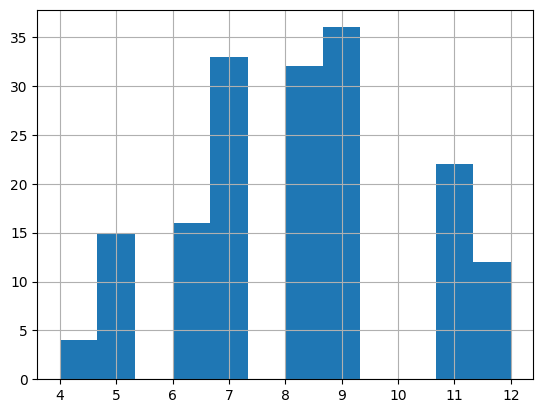

In [72]:
race_info = ['RaceId', 'CourseId', 'CourseName', 'Off', 'HorseId', 'HorseName', 'HorseCount', 'JockeyId', 'JockeyName']

races_to_predict = todays_races[race_info + predictors].dropna().copy()

max_horses_in_race = races_to_predict["HorseCount"].max()
races_to_predict['HorseCount'].hist(bins=max_horses_in_race)

<Axes: >

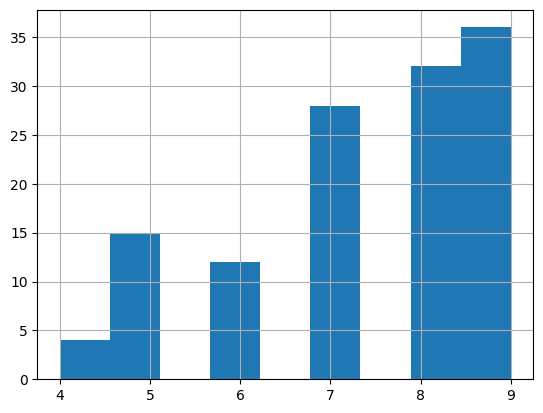

In [75]:
if len(races_to_predict) > 0:
    # Now that we've dropped any rows with na values, calculate which races in which we can predict the speed for all horses.
    races_to_predict = races_to_predict.drop("PredictableHorseCount", axis=1, errors='ignore')
    groups = races_to_predict.groupby(['RaceId'])['HorseId'].agg(['count']).rename(columns={'count': 'PredictableHorseCount'})
    races_to_predict = pd.merge(races_to_predict, groups, how='left', on=['RaceId'])
    races_to_predict = races_to_predict[(races_to_predict["HorseCount"] == races_to_predict["PredictableHorseCount"]) & (races_to_predict["HorseCount"] <= 10)]

max_horses_in_race = races_to_predict["HorseCount"].max()
races_to_predict['HorseCount'].hist(bins=max_horses_in_race)

In [76]:
test_inputs = races_to_predict[predictors]
predictions = model.predict(test_inputs)
races_to_predict["PredictedSpeed"] = predictions

In [77]:
races_to_predict["PredictedRank"] = races_to_predict.groupby("RaceId")["PredictedSpeed"].rank(method="dense", ascending=False)

In [78]:
todays_predictions = (races_to_predict[races_to_predict["PredictedRank"] == 1]
    .sort_values(["CourseName", "Off"])
    [["RaceId", "CourseId", "CourseName", "Off", "HorseId", "HorseName"]])

todays_predictions.to_csv("TodaysPredictions.csv", index=False)

todays_predictions

,RaceId,CourseId,CourseName,Off,HorseId,HorseName
36,859208,8,Carlisle,2024-02-19 14:00:00,4853584,Get A Superstar
46,859207,8,Carlisle,2024-02-19 14:30:00,4658876,Jagwar
50,859204,8,Carlisle,2024-02-19 15:00:00,2591996,Fiston De Becon
55,859206,8,Carlisle,2024-02-19 15:30:00,5202347,R S Ambush
67,859202,8,Carlisle,2024-02-19 16:00:00,3538526,East Street
73,859203,8,Carlisle,2024-02-19 16:35:00,4853677,Booster Bob
78,859205,8,Carlisle,2024-02-19 17:10:00,3254677,Kiss My Face
1,859363,393,Lingfield (AW),2024-02-19 13:17:00,4826976,Hatadora
7,859358,393,Lingfield (AW),2024-02-19 13:47:00,4346562,McLean House
17,859364,393,Lingfield (AW),2024-02-19 14:47:00,5154274,Gogo Yubari


In [79]:
print(f"Generated predictions for {len(todays_predictions)} races")
print(todays_predictions[["CourseName", "Off", "HorseName"]].to_string(index=False))

Generated predictions for 18 races
        CourseName                 Off       HorseName
          Carlisle 2024-02-19 14:00:00 Get A Superstar
          Carlisle 2024-02-19 14:30:00          Jagwar
          Carlisle 2024-02-19 15:00:00 Fiston De Becon
          Carlisle 2024-02-19 15:30:00      R S Ambush
          Carlisle 2024-02-19 16:00:00     East Street
          Carlisle 2024-02-19 16:35:00     Booster Bob
          Carlisle 2024-02-19 17:10:00    Kiss My Face
    Lingfield (AW) 2024-02-19 13:17:00        Hatadora
    Lingfield (AW) 2024-02-19 13:47:00    McLean House
    Lingfield (AW) 2024-02-19 14:47:00     Gogo Yubari
    Lingfield (AW) 2024-02-19 15:17:00 Sunset In Paris
    Lingfield (AW) 2024-02-19 15:47:00 Angel Of Antrim
Wolverhampton (AW) 2024-02-19 17:00:00         Daley T
Wolverhampton (AW) 2024-02-19 17:30:00           Coast
Wolverhampton (AW) 2024-02-19 18:00:00         Tuneful
Wolverhampton (AW) 2024-02-19 19:00:00    Rising Force
Wolverhampton (AW) 2024-02-19 